In [2]:
import numpy as np
import pandas as pd
from pprint import pprint
import csv
import matplotlib.pyplot as plt

In [3]:
def conv_num_to_bi(data,test_data, target_head="class"):
    med_d = data[target_head].median()
    min_d = data[target_head].min()
    max_d = data[target_head].max()
    bins = [min_d-1,med_d,max_d]
    data[target_head]=pd.cut(data[target_head],bins,labels=[0,1]) 
    test_data[target_head]=pd.cut(test_data[target_head],bins,labels=[0,1])


In [4]:
Head= ["Age","Job","Marital","Education","Default","Balance","Housing","Loan","Contact","Day","Month","Duration","Campaign","Pday","Previous","Poutcome","Label"]
Data=pd.read_csv('bank_data/train.csv',names=Head)
test_Data=pd.read_csv('bank_data/test.csv',names= Head)
       

Attributes=["Age","Job","Marital","Education","Default","Balance","Housing","Loan","Contact","Day","Month","Duration","Campaign","Pday","Previous","Poutcome"]
train_Data= Data[Attributes]
train_Label = Data["Label"]


n_data, dim = train_Data.shape
data = pd.DataFrame(Data.copy())
test_data =  pd.DataFrame(test_Data.copy())
# convert numeric data to binary
# train
conv_num_to_bi(data,test_data,"Age")
conv_num_to_bi(data,test_data,"Balance")
conv_num_to_bi(data,test_data,"Day")
conv_num_to_bi(data,test_data,"Duration")
conv_num_to_bi(data,test_data,"Campaign")
conv_num_to_bi(data,test_data,"Pday")
conv_num_to_bi(data,test_data,"Previous")
print(data.head())

  Age          Job  Marital  Education Default Balance Housing Loan   Contact  \
0   1     services  married  secondary      no       0     yes   no   unknown   
1   1  blue-collar   single  secondary      no       0     yes  yes  cellular   
2   1   technician  married  secondary      no       1      no  yes  cellular   
3   1       admin.  married   tertiary      no       0     yes   no  cellular   
4   0   management   single   tertiary      no       1      no   no  cellular   

  Day Month Duration Campaign Pday Previous Poutcome Label  
0   0   may        0        0    0        0  unknown    no  
1   0   feb        1        0    0        0  unknown    no  
2   1   aug        1        0    1        1  success   yes  
3   0   jul        1        0    0        0  unknown    no  
4   0   apr        0        0    0        0  unknown   yes  


In [5]:
# Assign the weights
data["weights"] = 1/len(data)
test_data["weights"] = 1/len(data)
#names of label should be "label"
data["label"] = data.Label
data["label"]=data.label.replace("no",-1)
data["label"]=data.label.replace("yes",1)
test_data["label"] = test_data.Label
test_data["label"]=test_data.label.replace("no",-1)
test_data["label"]=test_data.label.replace("yes",1)
print(data.head())

  Age          Job  Marital  Education Default Balance Housing Loan   Contact  \
0   1     services  married  secondary      no       0     yes   no   unknown   
1   1  blue-collar   single  secondary      no       0     yes  yes  cellular   
2   1   technician  married  secondary      no       1      no  yes  cellular   
3   1       admin.  married   tertiary      no       0     yes   no  cellular   
4   0   management   single   tertiary      no       1      no   no  cellular   

  Day Month Duration Campaign Pday Previous Poutcome Label  weights  label  
0   0   may        0        0    0        0  unknown    no   0.0002     -1  
1   0   feb        1        0    0        0  unknown    no   0.0002     -1  
2   1   aug        1        0    1        1  success   yes   0.0002      1  
3   0   jul        1        0    0        0  unknown    no   0.0002     -1  
4   0   apr        0        0    0        0  unknown   yes   0.0002      1  


In [6]:
def weighted_entropy(data,target): 
    p_label, p_count = np.unique(data[target],return_counts =True)
    prop=[]

    for f in p_label:
        p=0
        for i in data.index:
            if data[target][i]==f:
                p += data["weights"][i]
            else:
                p+= 0
                
        prop.append(p)
    
    entro=0
    for i in range(len(prop)):
        p= prop[i]/np.sum(prop)
        entro += -p*np.log(p)
        
    return entro

        


In [7]:
# weighted_info_gain(data,"attribute")

def weigthed_info_gain(data, attribute):
    total_entro = weighted_entropy(data,"label")
    

    feature, f_counts = np.unique(data[attribute],return_counts = True)

    weighted_entro = 0 

    for f in feature:
        sub_data= data[data[attribute]==f]
        
        p = weighted_entropy(sub_data,"label")
        weighted_entro +=p*len(sub_data)/len(data)
        

    info_gain = total_entro - weighted_entro
    
    return info_gain



In [8]:
def Common_label(data):
    
    feature,f_count = np.unique(data["label"],return_counts =True)
    W_counts = []
    for f in feature:
        sdata=data[data["label"]==f]
        weighted_count = np.sum(sdata["weights"])
        W_counts.append(weighted_count)

    common_label = feature[np.argmax(W_counts)]
    
    return common_label


In [9]:
def ID3_depth_entropy(depth, data,Attributes,label="class"):
    
    common_label=Common_label(data)
    
    # if all label_values have same value, return itself
    if len(np.unique(data[label])) <= 1:
        return common_label
        #return 

    # if feature space is empty, return the common label value
    elif len(Attributes)==0:
        return common_label

    # go to the scheme
    else:
       # select the attribute which best split the dataset using InfoGain
        
        item_values=[ weigthed_info_gain(data, f) for f in Attributes]

        best_attribute_index = np.argmax(item_values)
        best_attribute = Attributes[best_attribute_index]
        
        tree = {best_attribute:{}}

        
        # grow a branch under the root node
        for value in np.unique(data[best_attribute]):
            sub_data = data[data[best_attribute]== value]
            sub_common_label= Common_label(sub_data)

            if len(sub_data)==0 or depth==1:
                tree[best_attribute][value] = sub_common_label

            else:
                Attributes = [ i for i in Attributes if i != best_attribute]
                subtree=ID3_depth_entropy(depth-1,sub_data,Attributes,"label")
                tree[best_attribute][value]=subtree
        return tree

    

In [13]:
def predict(query,tree,default = 1):    
    
    for key in list(query.keys()):
        if key in list(tree.keys()):
          
            try:
                result = tree[key][query[key]] 
            except:
                return default
  
            #3.
            result = tree[key][query[key]]
            #4.
            if isinstance(result,dict):
                return predict(query,result)
            else:
                return result
        

###########################################################################################################
###########################################################################################################

def test(data,tree):
    label = data["label"]
    queries = data.iloc[:,:-1].to_dict(orient = "records")
    predicted = pd.DataFrame(columns=["predicted"]) 
    
    for i in range(len(data)):
        predicted.loc[i,"predicted"] = predict(queries[i],tree,1.0) 
        
    return predicted, np.sum(predicted["predicted"] != label)/len(data)*100


In [14]:
data["weights"] = 1/len(data)
Training_Error =[]
each_Error =[]
Testing_Error = []
test_each_Error=[]
n_iter = 0 
Final_pred=np.zeros((len(data),))
Test_Final_pred= np.zeros((len(test_data),))
for i in range(1000):
    epsilon = 0 
    alpha = 0
    tree = ID3_depth_entropy(1, data, Attributes,"Label")

    data["prediction"],acc =  test(data,tree)
    each_Error.append(acc)
    test_data["prediction"],test_acc =  test(test_data,tree)
    test_each_Error.append(test_acc)

    for i in range(len(data)):
        if data["prediction"][i]!= data["label"][i]:
            epsilon += data["weights"][i]

    alpha = np.log((1-epsilon)/epsilon)/2

    data["weights"] *= np.exp(-alpha*data["label"]*data["prediction"])
    data["weights"] = data["weights"]/np.sum(data["weights"])
    Final_pred += alpha*data["prediction"]
    Test_Final_pred += alpha*test_data["prediction"]

    n_iter +=1
    error = np.sum(np.sign(Final_pred) != data["label"])/len(data)*100
    
    test_error = np.sum(np.sign(Test_Final_pred) != test_data["label"])/len(test_data)*100
    Training_Error.append(error)
    Testing_Error.append(test_error)
    print(n_iter,error,test_error)
    print(n_iter,acc,test_acc)
    print("---------------------------------------------------------")


1 11.92 12.559999999999999
1 11.92 12.559999999999999
---------------------------------------------------------
2 11.92 12.559999999999999
2 41.099999999999994 40.38
---------------------------------------------------------
3 11.92 12.559999999999999
3 19.7 20.3
---------------------------------------------------------
4 11.92 12.559999999999999
4 61.980000000000004 61.44
---------------------------------------------------------
5 11.24 11.82
5 10.879999999999999 11.66
---------------------------------------------------------
6 11.24 11.82
6 80.36 79.82000000000001
---------------------------------------------------------
7 11.0 11.360000000000001
7 41.92 40.72
---------------------------------------------------------
8 11.0 11.360000000000001
8 41.099999999999994 40.38
---------------------------------------------------------
9 10.68 11.1
9 32.7 34.0
---------------------------------------------------------
10 10.68 11.1
10 73.72 73.83999999999999
-------------------------------------

83 10.36 10.74
83 86.38 86.16
---------------------------------------------------------
84 10.38 10.76
84 41.099999999999994 40.38
---------------------------------------------------------
85 10.36 10.76
85 11.92 12.479999999999999
---------------------------------------------------------
86 10.36 10.76
86 86.38 86.16
---------------------------------------------------------
87 10.36 10.780000000000001
87 23.0 23.46
---------------------------------------------------------
88 10.36 10.82
88 68.66 68.14
---------------------------------------------------------
89 10.34 10.82
89 72.58 72.48
---------------------------------------------------------
90 10.34 10.8
90 12.9 13.3
---------------------------------------------------------
91 10.34 10.8
91 58.08 59.28
---------------------------------------------------------
92 10.32 10.8
92 61.980000000000004 61.44
---------------------------------------------------------
93 10.299999999999999 10.82
93 73.72 73.83999999999999
-------------------

164 10.299999999999999 10.82
164 60.5 60.519999999999996
---------------------------------------------------------
165 10.299999999999999 10.84
165 37.059999999999995 38.24
---------------------------------------------------------
166 10.299999999999999 10.82
166 77.5 77.18
---------------------------------------------------------
167 10.299999999999999 10.82
167 11.92 12.479999999999999
---------------------------------------------------------
168 10.299999999999999 10.82
168 86.38 86.16
---------------------------------------------------------
169 10.299999999999999 10.82
169 50.32 49.86
---------------------------------------------------------
170 10.299999999999999 10.82
170 21.84 21.9
---------------------------------------------------------
171 10.32 10.82
171 49.04 49.16
---------------------------------------------------------
172 10.299999999999999 10.82
172 86.38 86.16
---------------------------------------------------------
173 10.299999999999999 10.82
173 73.72 73.83999999

240 10.299999999999999 10.82
240 11.88 12.280000000000001
---------------------------------------------------------
241 10.299999999999999 10.84
241 86.38 86.16
---------------------------------------------------------
242 10.299999999999999 10.84
242 73.72 73.83999999999999
---------------------------------------------------------
243 10.299999999999999 10.84
243 11.92 12.479999999999999
---------------------------------------------------------
244 10.299999999999999 10.84
244 75.96000000000001 75.38
---------------------------------------------------------
245 10.280000000000001 10.82
245 16.78 17.16
---------------------------------------------------------
246 10.280000000000001 10.82
246 52.32 52.959999999999994
---------------------------------------------------------
247 10.280000000000001 10.82
247 84.88 84.72
---------------------------------------------------------
248 10.280000000000001 10.82
248 11.92 12.479999999999999
-------------------------------------------------------

KeyboardInterrupt: 

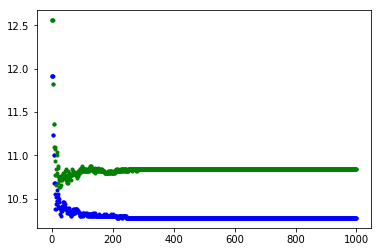

In [45]:
plt.plot(range(n_iter),Training_Error,'b.')
plt.plot(range(n_iter),Testing_Error,'g.')

In [50]:
a = Training_Error[0:500,:]
plt.plot(range(500),Training_Error,'b.')

TypeError: list indices must be integers or slices, not tuple

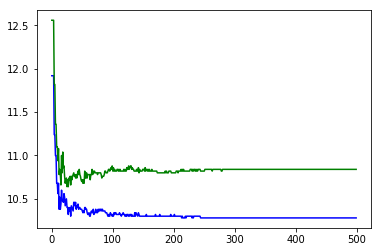

In [59]:
a= Training_Error[0:500]
te=Testing_Error[0:500]
plt.plot(range(len(a)),a,'b-')
plt.plot(range(len(a)),te,'g-')

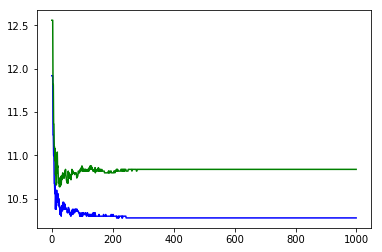

In [60]:
plt.plot(range(n_iter),Training_Error,'b-')
plt.plot(range(n_iter),Testing_Error,'g-')

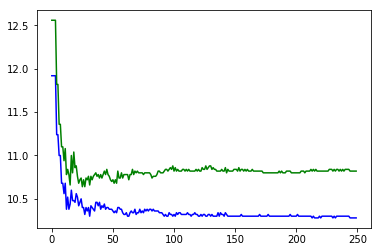

In [15]:
a= Training_Error[0:250]
te=Testing_Error[0:250]
plt.plot(range(len(a)),a,'b-')
plt.plot(range(len(a)),te,'g-')

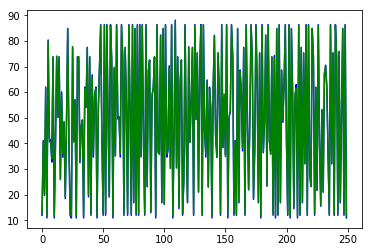

In [19]:

b= each_Error[0:250]
teb=test_each_Error[0:250]


plt.plot(range(len(b)),b,'b')
plt.plot(range(len(b)),teb,'g')

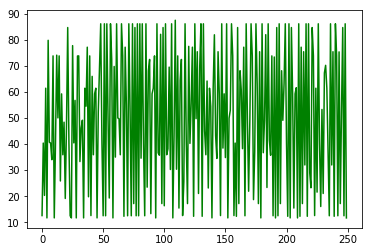

In [18]:
plt.plot(range(len(b)),teb,'g-')